# *Traffic Sign Recognizer*

## Importing Required Libraries
导入库

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

## Assigning Path for Dataset
数据集路径

In [2]:
#data_dir = '../input/gtsrb-german-traffic-sign'
#train_path = '../input/gtsrb-german-traffic-sign/Train'
#test_path = '../input/gtsrb-german-traffic-sign/'


#  这里是我自己的路径，需修改成自己的数据文件路径
data_dir = './archive'
train_path = './archive/Train'
test_path = './archive'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes
所有类别

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset
数据可视化：每个类别数据量

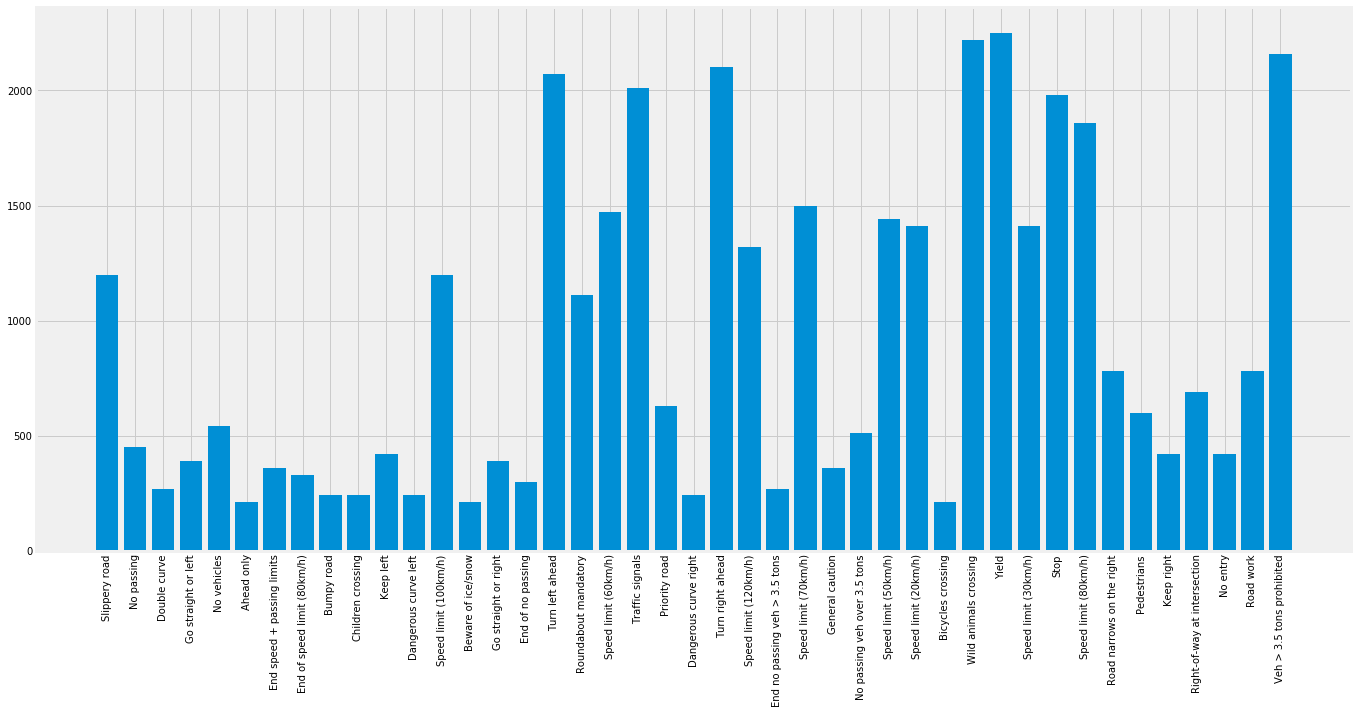

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

随机查看测试集

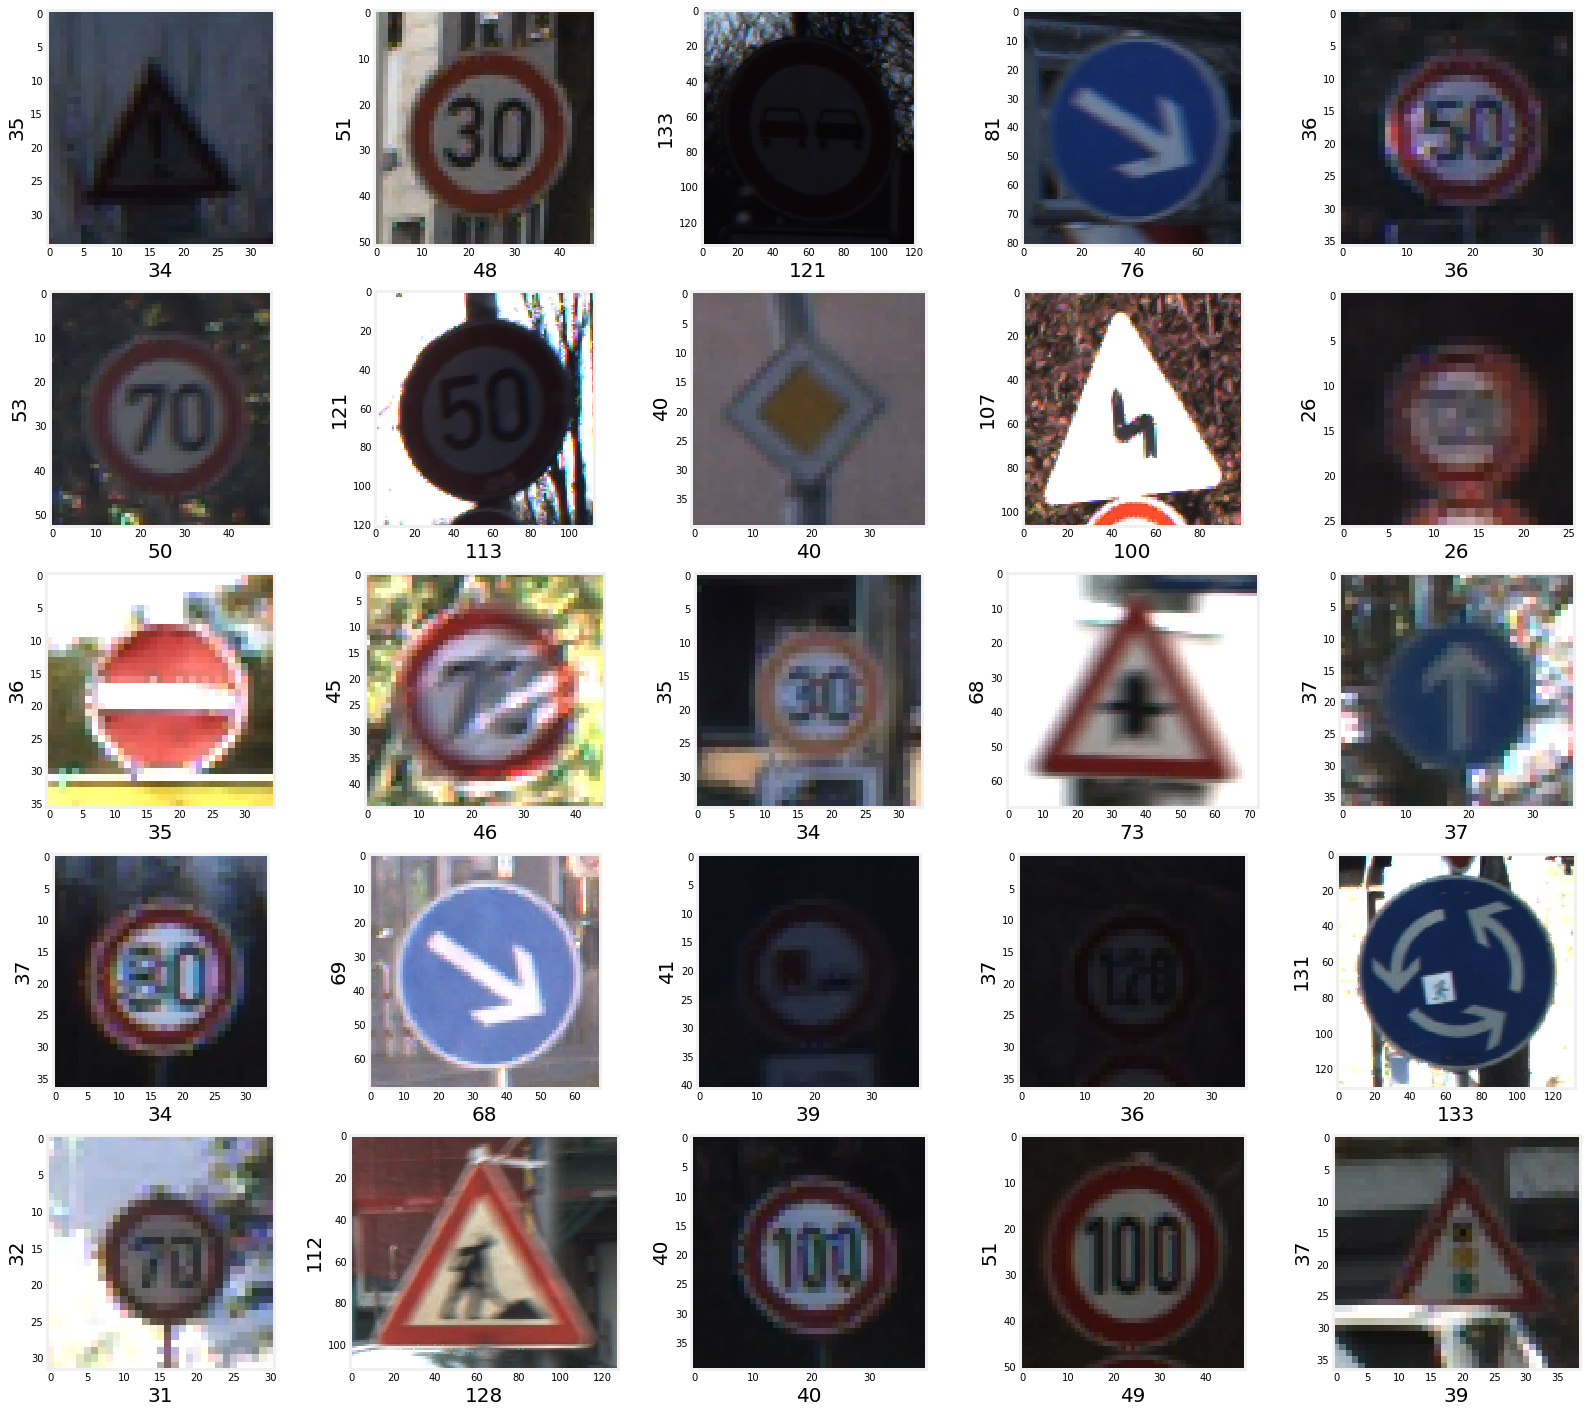

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data
训练集

In [7]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## 进行PCA、LDA处理

* PCA：非监督降维，降维后数据的方差尽可能的大（方差大，含有的信息量就大）
* LDA：有监督降维，降维后，组内（同一类别）方差小，组间（不同类别之间）方差大

变换后的数据不具备可解释性。因此，降维的操作比较适合在高维度下进行


### PCA处理流程

1. 已有各特征的平均值，对应的减去相应的均值
2. 求出特征的协方差矩阵，就是特征两两之间的相关性
3. 求出协方差矩阵的特征值和特征矩阵
4. 将特征值按从大到小的顺序排序，选择其中最大的K个，然后将其对一个的K个特征向量分别作为列向量组成特征向量矩阵
5. 将样本点投射到选取的特征向量上。假设样例数为m，特征数为n，减去均值后的样本矩阵为DataAdjust(m*n)，协方差矩阵是n*n，选取的k个特征向量组成的矩阵为EigenVectors(n*k)。那么投影后的数据FinalData为：FinalData(m*k) = DataAdjust(m*n) * EigenVectors(n*k)
<br>
<br>
理论基础
<br>
最大方差理论、最小错误理论和坐标轴相关度理论<br>
在信号处理中认为信号具有较大的方差，噪声有较小的方差，信噪比就是信号与噪声的方差比，越大越好。<br>
因此我们认为，最好的k维特征是将n维样本点转换为k维后，每一维上的样本方差都很大。<br>

#### PCA理论意义
PCA将n个特征降维到k个，可以用来进行数据压缩，如果100维的向量最后可以用10维来表示，那么压缩率为90%。同样图像处理领域的KL变换使用PCA做图像压缩。但PCA要保证降维后，还要保证数据的特性损失最小。

#### PCA总结
PCA技术的一个很大的优点是，它是完全无参数限制的。在PCA的计算过程中完全不需要人为的设定参数或是根据任何经验模型对计算进行干预，最后的结果只与数据相关，与用户是独立的。 <br>
但是，这一点同时也可以看作是缺点。如果用户对观测对象有一定的先验知识，掌握了数据的一些特征，却无法通过参数化等方法对处理过程进行干预，可能会得不到预期的效果，效率也不高。<br>

### LDA
LDA与PCA相似，也是一种常用于降维任务的线性变换方法。但与后者是一种无监督学习算法不同，LDA属于有监督学习方法的一类。因此，LDA的目标是利用类标签的可用信息，通过计算组件轴(线性判别器)来最大化不同类之间的分离。
1. 标准化d维数据表（d是特征数）；
2. 对于每一类，计算d维平均向量；
3. 构建类间分布矩阵SB和类内分布矩阵SW；
4. 计算矩阵特征向量和相应的特征值SW-1SB；
5. 按降序对特征值进行排序，以对相应的特征向量进行排序；
6. 选择与k个最大特征值相对应的k个特征向量，构建d*k维转换矩阵W；特征向量为矩阵的列；
7. 使用转换矩阵W将样本数据映射到新的特征子空间。

参考博客:
<br>
[数据挖掘：特征提取--PCA与LDA](https://blog.csdn.net/AvenueCyy/article/details/105249265)
<br>
[sklearn库LDA进行图片数据降维](https://blog.csdn.net/qq_29848559/article/details/87900654)
<br>
[sklearn库PCA函数进行数字图片降维](https://blog.csdn.net/qq_29848559/article/details/87890921)

In [8]:
#  将30*30*3 转成一维矩阵

reshape_image_data = image_data.reshape(image_data.shape[0], -1)
reshape_image_data.shape

(39209, 2700)

In [9]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import  StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import time

## Shuffling the training data

In [10]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [11]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [12]:
#  将30*30*3 转成一维矩阵

reshape_X_train = X_train.reshape(X_train.shape[0], -1)
reshape_X_val = X_val.reshape(X_val.shape[0], -1)
print(reshape_X_train.shape)
print(reshape_X_val.shape)

(27446, 2700)
(11763, 2700)


## PCA转换
484维 大约为保留99%的特征信息

In [13]:
N1 = 484
pca = PCA(n_components=N1)
pca.fit(reshape_X_train)
train_data_pca = pca.transform(reshape_X_train)
test_data_pca = pca.transform(reshape_X_val)
train_data_pca.shape

(27446, 484)

In [38]:
test_data_pca.shape

(11763, 484)

## PCA第一、第二特征向量

In [19]:
# 第一、第二特征向量包含的信息量占比

pca.explained_variance_ratio_[:2]

array([0.47883842, 0.1387149 ])

In [15]:
first_matrix = pca.components_[0]
first_matrix

array([0.0214006 , 0.02238707, 0.02258841, ..., 0.0172404 , 0.0183206 ,
       0.01868485])

In [16]:
second_matrix = pca.components_[1]
second_matrix

array([0.02631126, 0.02314603, 0.02080233, ..., 0.00986825, 0.00732914,
       0.00593899])

In [20]:
lr=0.0003
epochs=10

## 原始30x30x3 输入BP网络

In [21]:
#创建模型,输入2700个神经元,输出43个神经元
model1=keras.models.Sequential([
    keras.layers.Dense(units=200,input_dim=2700,activation='tanh'),
    keras.layers.Dense(units=100,activation='tanh'),
    keras.layers.Dense(units=43,activation='softmax')
])
#定义优化器
opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
#定义loss func
model1.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#训练模型
history1 = model1.fit(reshape_X_train,y_train,batch_size=32,epochs=10)


Epoch 1/10
27446/27446 [==============================] - 9s 343us/step - loss: 1.9158 - acc: 0.5189
Epoch 2/10
27446/27446 [==============================] - 9s 324us/step - loss: 0.8195 - acc: 0.8020
Epoch 3/10
27446/27446 [==============================] - 9s 317us/step - loss: 0.5298 - acc: 0.8734
Epoch 4/10
27446/27446 [==============================] - 9s 329us/step - loss: 0.4004 - acc: 0.9011
Epoch 5/10
27446/27446 [==============================] - 9s 336us/step - loss: 0.3295 - acc: 0.9172
Epoch 6/10
27446/27446 [==============================] - 9s 327us/step - loss: 0.2677 - acc: 0.9349
Epoch 7/10
27446/27446 [==============================] - 9s 327us/step - loss: 0.2360 - acc: 0.9408
Epoch 8/10
27446/27446 [==============================] - 9s 328us/step - loss: 0.2060 - acc: 0.9494
Epoch 9/10
27446/27446 [==============================] - 10s 350us/step - loss: 0.1821 - acc: 0.9561
Epoch 10/10
27446/27446 [==============================] - 9s 319us/step - loss: 0.1615 - 

In [22]:
#评估模型
loss,accuracy=model1.evaluate(reshape_X_val,y_val)

print('test loss:',loss)
print('test accuracy:',accuracy)

print('train loss:',loss)
print('train accuracy:',accuracy)

11763/11763 [==============================] - 1s 51us/step
test loss: 0.2549430326413999
test accuracy: 0.9306299413161588
train loss: 0.2549430326413999
train accuracy: 0.9306299413161588


### BP网络直接输入原始30x30x3=>2700的数据
测试集的结果<br>

test loss: 0.3031523422852145<br>
test accuracy: 0.90878177<br>
train loss: 0.3031523422852145<br>
train accuracy: 0.90878177

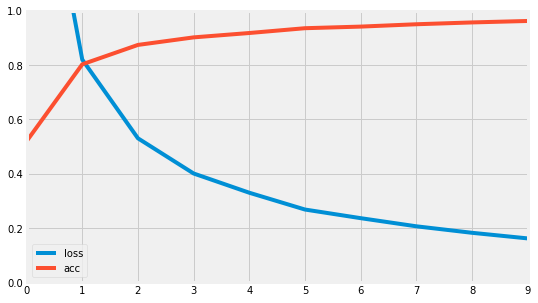

In [23]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## 添加了PCA后BP网络

In [24]:

#创建模型,输入484个神经元,输出43个神经元
model2=keras.models.Sequential([
    keras.layers.Dense(units=200,input_dim=484,activation='tanh'),
    keras.layers.Dense(units=100,activation='tanh'),
    keras.layers.Dense(units=43,activation='softmax')
])
#定义优化器
opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
#定义loss func
model2.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#训练模型
history2 = model2.fit(train_data_pca,y_train,batch_size=32,epochs=10)



Epoch 1/10
27446/27446 [==============================] - 3s 100us/step - loss: 1.8638 - acc: 0.5791
Epoch 2/10
27446/27446 [==============================] - 2s 85us/step - loss: 0.6230 - acc: 0.8787
Epoch 3/10
27446/27446 [==============================] - 2s 82us/step - loss: 0.3568 - acc: 0.9317
Epoch 4/10
27446/27446 [==============================] - 2s 74us/step - loss: 0.2509 - acc: 0.9504
Epoch 5/10
27446/27446 [==============================] - 2s 84us/step - loss: 0.1925 - acc: 0.9622
Epoch 6/10
27446/27446 [==============================] - 2s 86us/step - loss: 0.1545 - acc: 0.9712
Epoch 7/10
27446/27446 [==============================] - 2s 85us/step - loss: 0.1273 - acc: 0.9763
Epoch 8/10
27446/27446 [==============================] - 2s 82us/step - loss: 0.1067 - acc: 0.9815
Epoch 9/10
27446/27446 [==============================] - 2s 74us/step - loss: 0.0910 - acc: 0.9841
Epoch 10/10
27446/27446 [==============================] - 2s 79us/step - loss: 0.0778 - acc: 0.987

In [25]:
#评估模型
loss,accuracy=model2.evaluate(test_data_pca,y_val)

print('test loss:',loss)
print('test accuracy:',accuracy)

print('train loss:',loss)
print('train accuracy:',accuracy)

11763/11763 [==============================] - 0s 29us/step
test loss: 0.18852055503997148
test accuracy: 0.9512879367862987
train loss: 0.18852055503997148
train accuracy: 0.9512879367862987


## 测试集经过PCA处理后，在BP网络效果

test loss: 0.1299617305688714<br>
test accuracy: 0.9675253<br>
train loss: 0.1299617305688714<br>
train accuracy: 0.9675253

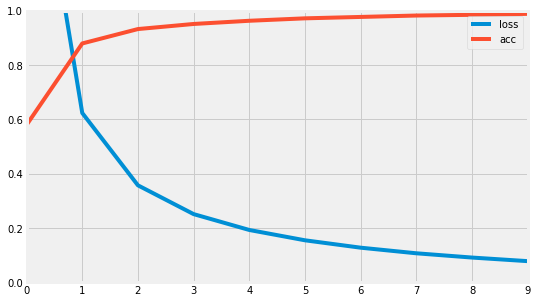

In [26]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## PCA之后，再LDA处理


In [27]:
lda = LDA(n_components=42)
lda.fit(train_data_pca, y_train)
train_data_lda = lda.transform(train_data_pca)
test_data_lda = lda.transform(test_data_pca)

In [28]:
train_data_lda.shape

(27446, 42)

In [29]:
#创建模型,输入242个神经元,输出43个神经元
model3=keras.models.Sequential([
    keras.layers.Dense(units=200,input_dim=42,activation='tanh'),
    keras.layers.Dense(units=100,activation='tanh'),
    keras.layers.Dense(units=43,activation='softmax')
])
#定义优化器
opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
#定义loss func
model3.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#训练模型
history3 = model3.fit(train_data_lda,y_train,batch_size=32,epochs=10)

Epoch 1/10
27446/27446 [==============================] - 1s 55us/step - loss: 1.0438 - acc: 0.8112
Epoch 2/10
27446/27446 [==============================] - 1s 43us/step - loss: 0.3755 - acc: 0.9201
Epoch 3/10
27446/27446 [==============================] - 1s 48us/step - loss: 0.2856 - acc: 0.9345
Epoch 4/10
27446/27446 [==============================] - 1s 46us/step - loss: 0.2451 - acc: 0.9408: 0s - loss: 0.2
Epoch 5/10
27446/27446 [==============================] - 1s 43us/step - loss: 0.2198 - acc: 0.9467
Epoch 6/10
27446/27446 [==============================] - 1s 49us/step - loss: 0.2018 - acc: 0.9496
Epoch 7/10
27446/27446 [==============================] - 1s 44us/step - loss: 0.1877 - acc: 0.9525
Epoch 8/10
27446/27446 [==============================] - 1s 47us/step - loss: 0.1761 - acc: 0.9544
Epoch 9/10
27446/27446 [==============================] - 1s 44us/step - loss: 0.1665 - acc: 0.9577
Epoch 10/10
27446/27446 [==============================] - 1s 45us/step - loss: 0.15

In [30]:
#评估模型
loss,accuracy=model3.evaluate(test_data_lda,y_val)

print('test loss:',loss)
print('test accuracy:',accuracy)

print('train loss:',loss)
print('train accuracy:',accuracy)

11763/11763 [==============================] - 0s 21us/step
test loss: 0.23875417998835696
test accuracy: 0.9314800646448382
train loss: 0.23875417998835696
train accuracy: 0.9314800646448382


## 测试集经过PCA处理后，又经历LDA处理后的结果，在BP网络效果


test loss: 0.16689368259422352<br>
test accuracy: 0.95460343<br>
train loss: 0.16689368259422352<br>
train accuracy: 0.95460343

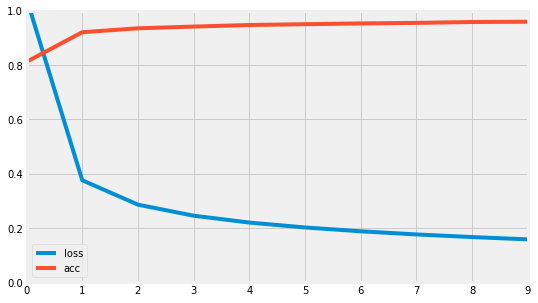

In [31]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [32]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255



In [34]:
# model1原始数据训练的
test_reshape_X_test = X_test.reshape(X_test.shape[0], -1)
pred = model1.predict_classes(test_reshape_X_test)

#Accuracy with the test data
print('Model1 Test Data accuracy: ',accuracy_score(labels, pred)*100)

Model1 Test Data accuracy:  82.98495645288995


In [36]:
print('Model1 Test Error Rate:', (1 - accuracy_score(labels, pred))*100 )

Model1 Test Error Rate: 17.015043547110054


In [37]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.58      0.48      0.53        60
           1       0.77      0.85      0.81       720
           2       0.93      0.75      0.83       750
           3       0.75      0.64      0.69       450
           4       0.83      0.79      0.81       660
           5       0.54      0.91      0.68       630
           6       0.72      0.65      0.69       150
           7       0.92      0.65      0.76       450
           8       0.73      0.88      0.80       450
           9       0.98      0.87      0.92       480
          10       0.91      0.92      0.91       660
          11       0.95      0.75      0.84       420
          12       0.99      0.94      0.96       690
          13       0.97      0.98      0.98       720
          14       0.99      0.93      0.96       270
          15       0.91      0.93      0.92       210
          16       0.96      0.95      0.95       150
          17       0.99    

In [38]:
# model2 PCA 数据训练的

test_reshape_data_pca = pca.transform(test_reshape_X_test)

pred = model2.predict_classes(test_reshape_data_pca)

#Accuracy with the test data
print('Model2 Test Data accuracy: ',accuracy_score(labels, pred)*100)

Model2 Test Data accuracy:  86.73792557403009


In [39]:
print('Model2 Test Error Rate:', (1 - accuracy_score(labels, pred))*100 )

Model2 Test Error Rate: 13.262074425969917


In [40]:

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.90      0.45      0.60        60
           1       0.78      0.85      0.82       720
           2       0.83      0.88      0.85       750
           3       0.74      0.76      0.75       450
           4       0.84      0.85      0.84       660
           5       0.75      0.84      0.79       630
           6       0.93      0.69      0.79       150
           7       0.89      0.74      0.81       450
           8       0.84      0.87      0.85       450
           9       0.94      0.92      0.93       480
          10       0.93      0.96      0.95       660
          11       0.87      0.88      0.88       420
          12       0.99      0.94      0.97       690
          13       0.97      0.98      0.98       720
          14       0.98      0.94      0.96       270
          15       0.87      0.86      0.86       210
          16       0.88      0.91      0.89       150
          17       0.98    

In [41]:
# model3 PCA后，LDA 数据训练的
test_lda_data_lda = lda.transform(test_reshape_data_pca)

pred = model3.predict_classes(test_lda_data_lda)

#Accuracy with the test data
print('Model3 Test Data accuracy: ',accuracy_score(labels, pred)*100)

Model3 Test Data accuracy:  86.326207442597


In [42]:
print('Model3 Test Error Rate:', (1 - accuracy_score(labels, pred))*100 )

Model3 Test Error Rate: 13.673792557403008


In [43]:

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.87      0.68      0.77        60
           1       0.81      0.87      0.84       720
           2       0.78      0.89      0.83       750
           3       0.74      0.75      0.75       450
           4       0.84      0.83      0.84       660
           5       0.71      0.77      0.73       630
           6       0.89      0.67      0.76       150
           7       0.87      0.71      0.78       450
           8       0.79      0.85      0.82       450
           9       0.94      0.94      0.94       480
          10       0.93      0.96      0.95       660
          11       0.84      0.86      0.85       420
          12       0.99      0.94      0.97       690
          13       0.98      0.98      0.98       720
          14       0.98      0.95      0.97       270
          15       0.86      0.82      0.84       210
          16       0.97      0.91      0.94       150
          17       0.99    

## 结论

1. 使用BP网络对一维数据（30x30x3=2700）进行训练，得到model1
2. PCA降维，从2700维降到484维，得到model2
3. PCA降维，又经历了LDA降维，从484维降到了42维， 得到了model3
4. 训练时长：mode1>model2>model3
5. 验证集的结果：model2>model3>model1
6. 测试集的结果：model2>model4>model1


## 改进建议

1. 由于使用BP网络进行图片分类，对特征提取的能力较差，所以降维后分类的准确率低于90%，因此，如果使用尽可能多的提取特征的神经网络，建议使用CNN。因为CNN有多层卷积核和池化层，能够自动提取特征并降维。
2. PCA能够保证提取特征信息量占99%时，特征维度可以降至18%，准确率略微的提升，但是，并没有各个维度的解释性，并不知道新生成的特征的含义。如果想通过降维、又能明确特征的含义，建议结合已知专业知识，通过特征工程构建新的可解释特征，进行模型训练。